# $\textit{Analisis de respuestas impulsivas}$
$\textit{Filtro lineal optimo}$

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import scipy.signal as sp
import scipy.io as io
import scipy.linalg as lin

In [21]:
%matplotlib widget

In [22]:
fs = 48000

In [23]:
t = np.linspace(0, 10, 10*fs, endpoint=False)
f0 = 20
f1 = 20000
T = 10
k = (f1/f0)**(1/T)

chirpLinearSignal = sp.chirp(t, f0=f0, t1=10, f1=f1, method='linear')

chirpExpSignal = np.sin(2 * np.pi * f0 * (k**t-1)/np.log(k))

gaussSignal = np.random.normal(0, 1, size=fs*10)

squareSignal = sp.square(2 * np.pi * 100 * t)



In [24]:
# io.wavfile.write("chirpLinearSignal.wav", fs, chirpLinearSignal)
# io.wavfile.write("chirpExpSignal.wav", fs, chirpExpSignal)
# io.wavfile.write("noiseSignal.wav", fs, gaussSignal)
# io.wavfile.write("squareSignal.wav", fs, squareSignal)

In [25]:
def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = sp.spectrogram(w, fs=fs, nperseg=256, nfft=576)
    fig, ax = plt.subplots()
    ax.pcolormesh(tt, ff, Sxx, cmap='gray_r',
                  shading='gouraud')
    ax.set_title(title)
    ax.set_xlabel('t (sec)')
    ax.set_ylabel('Frequency (Hz)')
    ax.grid(True)


In [26]:
fs1, musicSignal = io.wavfile.read("musicSignal.wav")
fs2, VoiceSignal = io.wavfile.read("VoiceSignal.wav")
fs3, chirpLinearSignal = io.wavfile.read("chirpLinearSignal.wav")
fs4, chirpExpSignal = io.wavfile.read("chirpExpSignal.wav")
fs5, gaussSignal = io.wavfile.read("noiseSignal.wav")
fs6, squareSignal = io.wavfile.read("squareSignal.wav")

In [27]:
fs1, recmusicSignal = io.wavfile.read("recmusicSignal.wav")
fs2, recVoiceSignal = io.wavfile.read("recVoiceSignal.wav")
fs3, recchirpLinearSignal = io.wavfile.read("recchirpLinearSignal.wav")
fs4, recchirpExpSignal = io.wavfile.read("recchirpExpSignal.wav")
fs5, recgaussSignal = io.wavfile.read("recnoiseSignal.wav")
fs6, recsquareSignal = io.wavfile.read("recsquareSignal.wav")

recmusicSignal = (recmusicSignal.T)[1]
recVoiceSignal = (recVoiceSignal.T)[1]
recchirpLinearSignal = (recchirpLinearSignal.T)[1]
recchirpExpSignal = (recchirpExpSignal.T)[1]
recgaussSignal = (recgaussSignal.T)[1]
recsquareSignal = (recsquareSignal.T)[1]


C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_13784\2536659762.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, recmusicSignal = io.wavfile.read("recmusicSignal.wav")
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_13784\2536659762.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, recVoiceSignal = io.wavfile.read("recVoiceSignal.wav")
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_13784\2536659762.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs3, recchirpLinearSignal = io.wavfile.read("recchirpLinearSignal.wav")
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_13784\2536659762.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs4, recchirpExpSignal = io.wavfile.read("recchirpExpSignal.wav")
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_13784\2536659762.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs5, recgaussSignal = io.wavfile.read("recnoiseSignal.wav")
C:\Users\Gonzalo\

In [28]:
orgsignal = {"music": musicSignal, "voice": VoiceSignal, "chirpLin": chirpLinearSignal,
          "chirpExp": chirpExpSignal, "gauss": gaussSignal, "square": squareSignal}
recsignal = {"music": recmusicSignal, "voice": recVoiceSignal, "chirpLin": recchirpLinearSignal,
          "chirpExp": recchirpExpSignal, "gauss": recgaussSignal, "square": recsquareSignal}

In [29]:
ipd.Audio(squareSignal, rate=fs)

Comparamos los espectros de potencia

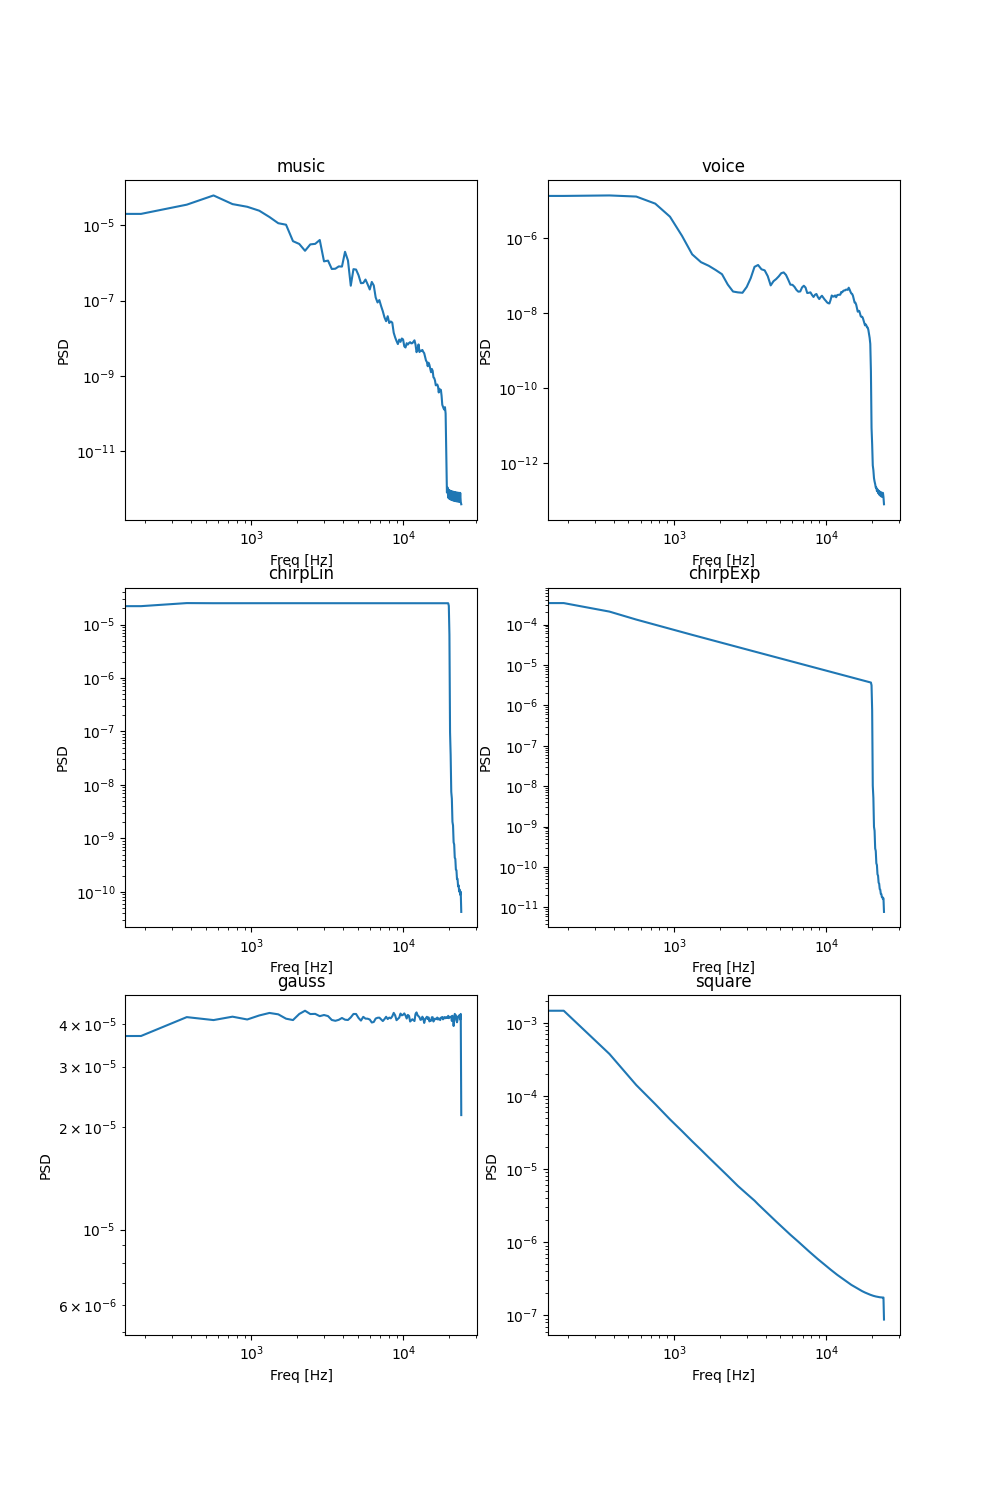

In [30]:
plt.figure(figsize=(10, 15))

for i, (name, s) in enumerate(zip(orgsignal.keys(), orgsignal.values())):
    f, Pxx_den = sp.welch(s, fs=fs, window='bartlett')
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.loglog(f, Pxx_den)

Viendo los espectrogramas anteriores, intuimos que la señal que mejor va funcionar para obtener h(n) es el barrido lineal porque excita al sistema (en este caso en el living de una casa) con un espectro de potencia mas constante que los demas. Este espectro plano permite que el resultado del filtro optimo ajuste directamente sobre el sistema q se quiere modelar y no tambien tome las caracteristicas de la señal que se esta utilizando. El ruido gaussiano tambien tiene una caracteristica plana, pero al ser una muestra de un ensamble no tiene un espectro realmente plano

# Modelado de sistema

$$ w_o = R^{-1}*p $$

$$ R = \begin{bmatrix}
Rxx(0) & Rxx (-1) & ... & Rxx(-(M-1)) \\
Rxx(-1) & Rxx (0) & ... & Rxx(-(M-2)) \\
... & & & \\

\end{bmatrix}
$$
$$ p = \begin{bmatrix}
Rxy(1) & Rxy (2) & ... & Rxy(M) \\

\end{bmatrix}
$$

![Alt text](image.png)

In [31]:
def get_optimal_params(x, y, M):
    N = len(x)
    r = sp.correlate(x, x)/N
    p = sp.correlate(x, y)/N
    r = r[N-1:N-1 + M]
    p = p[N-1:N-1-(M):-1]           # Correlate calcula la cross-corr r(-k), y necesitamos r(k), y esto no es par como la autocorrelacion
    wo = lin.solve_toeplitz(r, p)

    jo = np.var(y) - np.dot(p, wo)

    NMSE = jo/np.var(y)
    
    return wo, jo, NMSE


In [32]:
wo, jo, nmse = get_optimal_params(orgsignal['music'], recsignal['music'], 12500)

out = sp.lfilter(wo, [1.0], recsignal['music'])

print(nmse)


0.0399752791611667


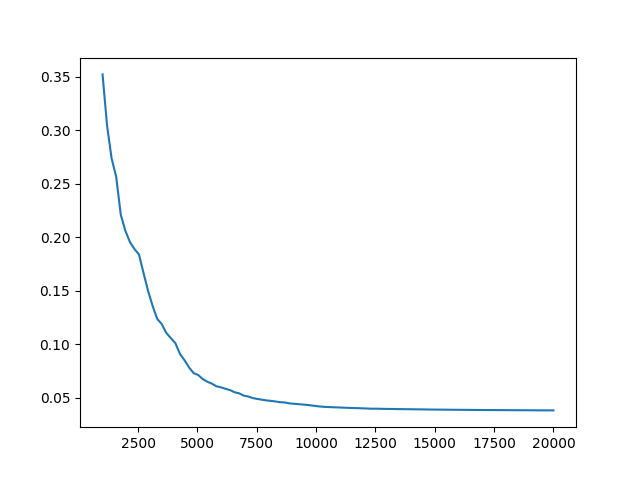

In [33]:
Ms = np.linspace(1000, 20000, 100, dtype=int)
jos = np.zeros(len(Ms))
for i, M in enumerate(Ms):
    wo, jo, nmse = get_optimal_params(orgsignal['music'], recsignal['music'], M)
    jos[i] = nmse

plt.figure()
plt.plot(Ms, jos)

In [34]:
ipd.Audio(orgsignal['music'], rate=fs)

In [35]:
ipd.Audio(recsignal['music'], rate=fs)

Obtenemos las respuestas al impulso de la habitacion para cada excitacion

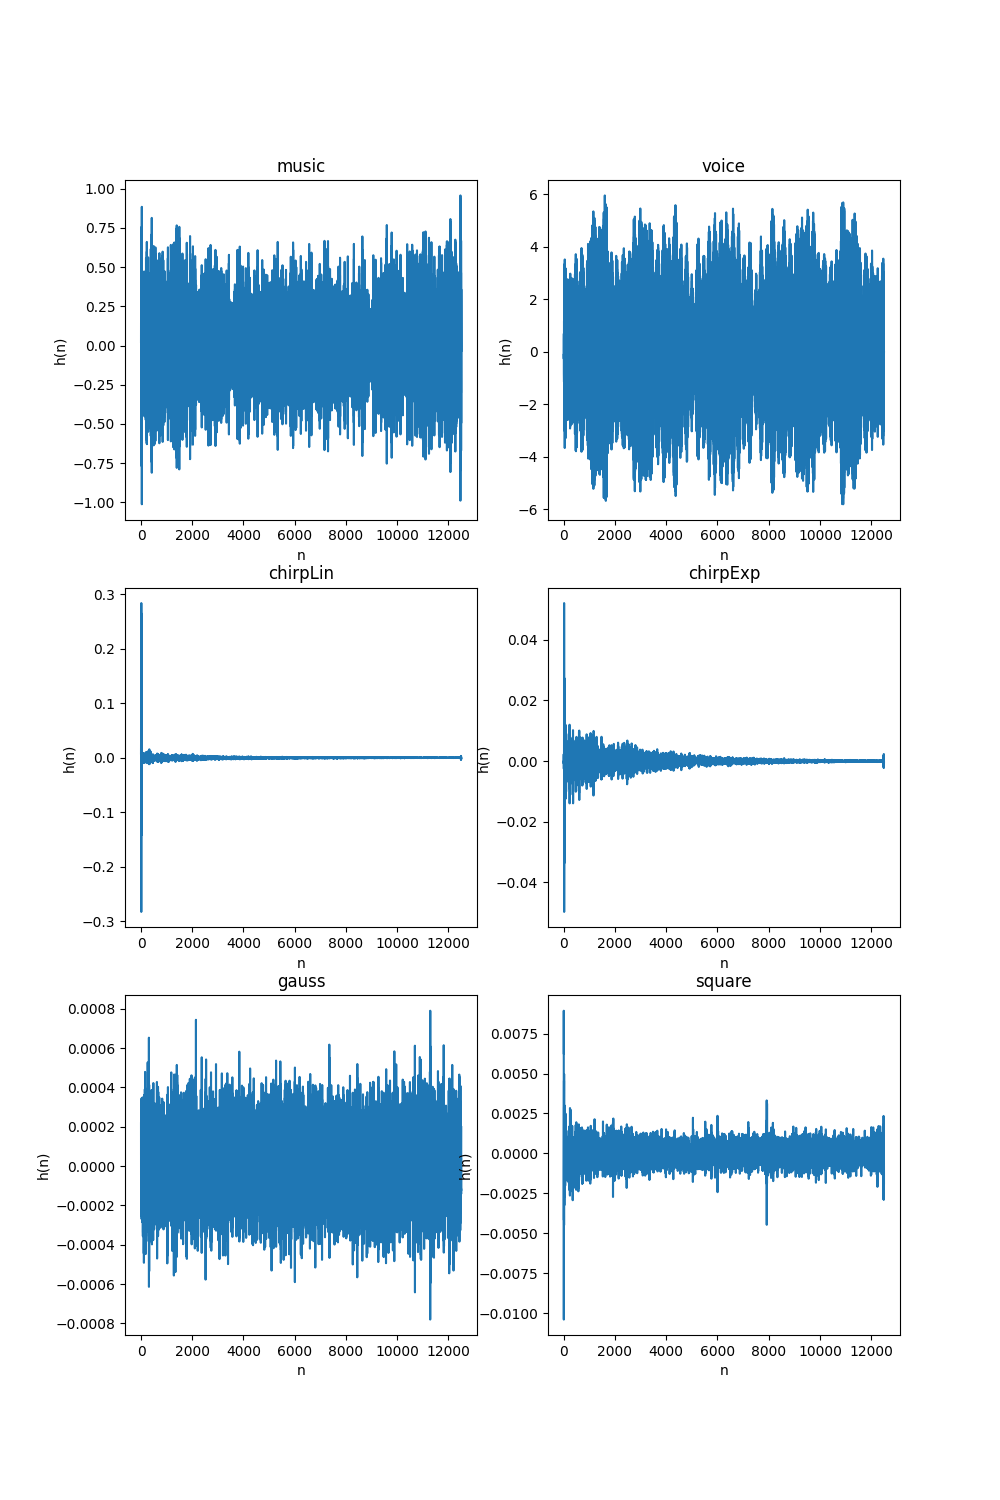

In [65]:
M = 12500 #Ordenes optimo encontrado
h_n = []

plt.figure(figsize=(10, 15))
for i, (name, os, rs) in enumerate(zip(orgsignal.keys(), orgsignal.values(), recsignal.values())):
    h, jo, nmse = get_optimal_params(os, rs, M)
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('n')
    plt.ylabel('h(n)')
    plt.plot(h)
    h_n.append(h)
plt.show()

Obtenemos la respuesta en frecuencia de cada estimacion de h(n)

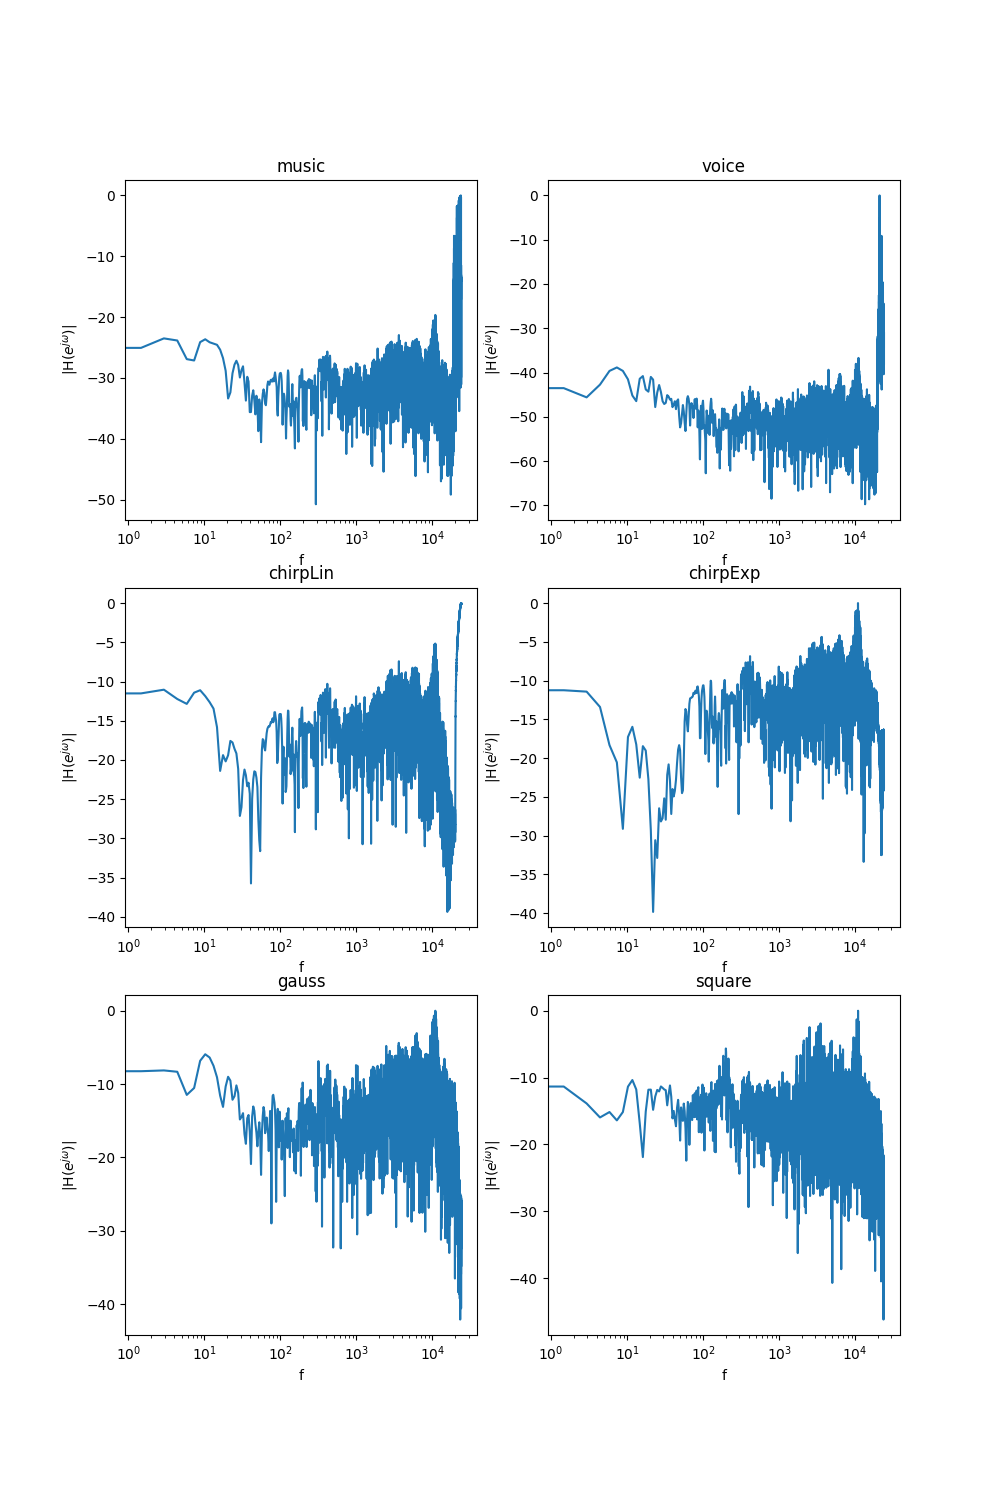

In [66]:
plt.figure(figsize=(10, 15))
for i, (name, h) in enumerate(zip(recsignal.keys(), h_n)):
    paddingLen = 2**(len(h)*2).bit_length()
    H = np.fft.rfft(h, paddingLen)
    f = np.fft.rfftfreq(paddingLen, 1/fs)

    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('f')
    plt.ylabel('|H($e^{j\omega}$)|')
    plt.semilogx(f, 10*np.log10(np.abs(H)/abs(H).max()))
plt.show()

Calculamos los MSE normalizados

In [38]:
#...